In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime, timedelta, date
import time
import os
import sys
import json
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
%load_ext autoreload
%autoreload 2

from helpers.db_query import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Weekly video count

In [4]:
video_dates = pd.read_csv('../data/lin_alg_moodle/videos.csv', index_col=0)
video_dates['Due_date'] = pd.to_datetime(video_dates.Due_date)

In [5]:
def select_by_year(video_dates, year):
    return video_dates.loc[video_dates.Due_date.dt.year == year]

video_dates_2017, video_dates_2018, video_dates_2019 = [select_by_year(video_dates, year) for year in [2017,2018, 2019]]

In [6]:
def weekly_count(video_dates):
    return video_dates.groupby(pd.Grouper(key='Due_date',freq='W-THU')).size().values

count_2017, count_2018, count_2019 = [weekly_count(dates) for dates in [video_dates_2017, video_dates_2018,video_dates_2019]]
print("2017", count_2017)
print("2018", count_2018)
print("2019", count_2019)

2017 [ 6  9  6 12  7]
2018 [ 7 10 10  6 13  7  8  7  9  6]
2019 [ 5  4  8  7  7 10 11 13  7  8  6  9  6]


# Features
## Video views

In [195]:
raw_events = getVideoEvents(mode='all')

In [197]:
inactives = getUnactiveStudentsIDs(raw_events)
print(len(inactives))

122


In [198]:
events = raw_events[~raw_events.AccountUserID.isin(inactives)]
print(raw_events.shape, events.shape)

(856427, 13) (750003, 13)


In [208]:
events.sample()

,DataPackageID,AccountUserID,VideoID,TimeStamp,EventType,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Date,Year
686909,EPFL-AlgebreLineaire-2019,100402,4a8019a55618419f9d97494e8deb46c1,1571652846,Video.Stop,None,NaN,725.563,NaN,NaN,NaN,2019-10-21 10:14:06,2019


In [202]:
user_events = events.loc[events.AccountUserID == '18422']

### Total views

In [182]:
def total_views(df):
    """ 
    Counts the total of videos views (rewatch included)
    Assumption: consider that a video is watched at most once per day
    """
    copy = df.copy()
    copy['Day'] = df.Date.dt.date
    #From the assumption the video view is a unique pair (video id, day)
    return len(copy.drop_duplicates(subset=['VideoID','Day'])) 
print("Total number of videos watched",total_views(user_events))

Total number of videos watched 4


### Proportion of videos watched/rewateched/interrutped

In [160]:
PATH = '../data/lin_alg_moodle/video_with_durations.csv'
original_dated_videos = pd.read_csv(PATH, index_col=0)

In [203]:
def week_video_total(year):
    """
    Returns a Series with week numbers as index and the number of videos to watch per week
    """
    with open('../config/linear_algebra.json') as f:
        config = json.load(f)
    year = str(year)
    weekly_count = config[year]["WeeklyVideoCount"]
    flipped_weeks = len(config[year]["FlippedWeeks"])
    start_week = int(datetime.strptime(config[year]["StartFlipped"], '%Y-%m-%d').strftime("%V")) #Get the 1st week number
    weeks = list(range(start_week, start_week + flipped_weeks))
    return pd.DataFrame(index=weeks, data=weekly_count, columns=["Total"])

def get_dated_videos():
    #PATH = '../data/lin_alg_moodle/video_with_durations.csv'
    #dated_videos = pd.read_csv(PATH, index_col=0)
    dated_videos = original_dated_videos
    dated_videos['Due_date'] = pd.to_datetime(dated_videos['Due_date']) #Convert String to datetime
    dated_videos['Year'] = dated_videos.Due_date.dt.year #Add year column
    return dated_videos

def videos_watched_on_right_week(user_events):
    dated_videos = get_dated_videos()
    first_views = user_events.merge(dated_videos, on=['VideoID', 'Year'])
    first_views['From_date'] = first_views.Due_date - timedelta(weeks=1)
    return first_views[(first_views.Date >= first_views.From_date) & (first_views.Date <= first_views.Due_date)]

def weekly_prop(user_events):
    """Compute the ratio of video events in the dataframe over the videos assigned weekly the user_events
    may only contained only the first viewings, only rewatched videos or only interrupted videos."""
    if len(user_events) == 0:
        return [0]
    first_views = videos_watched_on_right_week(user_events)
    #Freq Weekly starting on Thursday since the last due date is on Thursday
    weekly_count = first_views.groupby(pd.Grouper(key="Date", freq="W-THU")).size().to_frame(name="Count")
    #Convert dates to week number
    weekly_count.index = [int(week) for week in weekly_count.index.strftime("%V")]
    #Number of assigned videos per week
    weekly_total = week_video_total(user_events.Year.iloc[0])
    #Merge and compute the ratio of watched
    weekly_prop = weekly_total.merge(weekly_count, left_index=True, right_index=True, how='left')
    weekly_prop['Count'] = weekly_prop.Count.fillna(0)
    return np.clip((weekly_prop.Count / weekly_prop.Total).values,0,1)

#### Videos watched

In [204]:
# Average and SD of the proportion of videos watched per week
def weekly_prop_watched(user_events):
    """Compute the proportion of videos watched (nb of videos watched / nb of videos assigned)"""
    first_views = user_events.drop_duplicates(subset=["VideoID"]) #Only keep the first views per video
    return weekly_prop(first_views)

def avg_weekly_prop_watched(df): 
    return weekly_prop_watched(df).mean()

def std_weekly_prop_watched(df):
    return weekly_prop_watched(df).std()

print("Videos watched")
print("Average",avg_weekly_prop_watched(user_events))
print("SG",std_weekly_prop_watched(user_events))

Videos watched
Average 0.6972405372405373
SG 0.37290747472253855


#### Videos rewatched

In [205]:
# Average and SD of the proportion of videos replayed per week
def weekly_prop_replayed(user_events):
    """Compute the proportion of videos replayed (nb of videos replayed / nb of videos assigned)"""
    # We assume that a student watches a video at most once per day (cannot have multiple replays in one day)
    replayed_events = user_events.copy()
    replayed_events['Day'] = replayed_events.Date.dt.date #Create column with the date but not the time
    replayed_events.drop_duplicates(subset=['VideoID', 'Day'], inplace=True) #Only keep on event per video per day
    replayed_events = replayed_events[replayed_events.duplicated(subset=['VideoID'])] # Keep the replayed videos
    return weekly_prop(replayed_events)

def avg_weekly_prop_replayed(df): 
    return weekly_prop_replayed(df).mean()

def std_weekly_prop_replayed(df):
    return weekly_prop_replayed(df).std()

print("Videos replayed")
print("Average",avg_weekly_prop_replayed(user_events))
print("SG",std_weekly_prop_replayed(user_events))

Videos replayed
Average 0.08987484737484737
SG 0.09161292670783444


#### Videos interrupted

In [89]:
def weekly_prop_interrupted(user_events):
    STOP_EVENTS = ['Video.Pause', 'Video.Stop', 'Video.Load']
    df = user_events.copy() #Sort in descreasing order
    video_durations = get_dated_videos().drop_duplicates(subset=['VideoID'])[['VideoID', 'Duration']]
    df = df.merge(video_durations)
    df.sort_values(by="TimeStamp", inplace=True)
    df['Diff'] = abs(df.TimeStamp.diff(-1))
    df['NextVideoID'] = df.VideoID.shift(-1)
    
    df = df[(df.Duration - df.CurrentTime > 60)] #Remove events in the last minute
    # Interruption when
    #   * a break is too long
    #   * a break (not in the last minute) is followed by an event in another video (the user left the video)
    #   * an event occurs in another video before the end of the current video
    break_too_long = (df.EventType.isin(STOP_EVENTS)) & (df.Diff > 3600)
    break_then_other_video = (df.EventType.isin(STOP_EVENTS)) &  (df.VideoID != df.NextVideoID)
    event_other_video = (df.VideoID != df.NextVideoID) & ((df.Duration - df.CurrentTime) > (df.Diff))
    interrup_conditions = break_too_long | break_then_other_video | event_other_video
    df = df[interrup_conditions]
    return weekly_prop(df)

def avg_weekly_prop_interrupted(df): 
    return weekly_prop_interrupted(df).mean()

def std_weekly_prop_interrupted(df):
    return weekly_prop_interrupted(df).std()

print("Videos replayed")
print("Average",avg_weekly_prop_interrupted(user_events))
print("SG",std_weekly_prop_interrupted(user_events))

Videos replayed
Average 0.0
SG 0.0


#### Interruption exploration

There is no interruption event. In fact there exists an event called `Video.Stop` but it consists of the union of event types causing an interruption of the video, for instance `Video.Pause` or `Video.Load`. However I noticed that some events occurred at the same time as the end of the video: **is there a "closing event" that always occur at the end of the video?**

In order to test that, the `interruption` function returns the video events occurring in the `time_threshold` last seconds. By computing the proportion of videos where an event occurred in the last seconds and the total number of unique videos watched, we can have a approximative idea of how often an "interruption event" occurs.

In [13]:
def interruption(df, time_threshold=60):
    """Returns events occurring in the last time_threshold seconds (max one event per video) """
    user_event = df.copy()
    user_event['Day'] = user_event.Date.dt.date #Create column with the date but not the time
    dated_videos = get_dated_videos()
    user_event = user_event.merge(dated_videos, on=['VideoID', 'Year'])
    return user_event[abs(user_event.CurrentTime - user_event.Duration) <= time_threshold]\
                                                                    .drop_duplicates(subset=['VideoID'])

print("Number of videos containing an closing event:",len(interruption(user_events)))
print("Total number of distinct videos watched:", len(user_events.drop_duplicates(subset=['VideoID'])))

Number of videos containing an closing event: 70
Total number of distinct videos watched: 85


In [14]:
user_events

,DataPackageID,AccountUserID,VideoID,TimeStamp,EventType,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Date,Year
780862,EPFL-AlgebreLineaire-2018,47670,eaee610676f34fb9b729f3c5ba62499b,1541949476,Video.Seek,onSlideSeek,3.09653,NaN,544.0,NaN,NaN,2018-11-11 15:17:56,2018
780863,EPFL-AlgebreLineaire-2018,47670,5bc0ff2e9d6f4418927029a091383450,1545057343,Video.Play,None,NaN,599.2590,NaN,NaN,NaN,2018-12-17 14:35:43,2018
780864,EPFL-AlgebreLineaire-2018,47670,f63f35d6e527434cac3c8c8872f88270,1543843911,Video.Play,None,NaN,1148.8400,NaN,NaN,NaN,2018-12-03 13:31:51,2018
780865,EPFL-AlgebreLineaire-2018,47670,5513f6dfd7314224853327ea7b4e2dfc,1542028768,Video.Play,None,NaN,624.0000,NaN,NaN,NaN,2018-11-12 13:19:28,2018
780866,EPFL-AlgebreLineaire-2018,47670,4a3f41d9f86f4e7da9ebdc6e3a0173f7,1542287493,Video.Play,None,NaN,78.9593,NaN,NaN,NaN,2018-11-15 13:11:33,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783596,EPFL-AlgebreLineaire-2018,47670,6f7c4414324047a4b9d12a1d87d5875e,1542464281,Video.Seek,onSlideSeek,255.95500,NaN,80.0,NaN,NaN,2018-11-17 14:18:01,2018
783597,EPFL-AlgebreLineaire-2018,47670,8cf6c396f2114e0fa21a6309cf6626e1,1543335525,Video.Play,None,NaN,519.2020,NaN,NaN,NaN,2018-11-27 16:18:45,2018
783598,EPFL-AlgebreLineaire-2018,47670,ad4b668b3098404da342c8931fe1b2ea,1545065335,Video.Play,None,NaN,361.1310,NaN,NaN,NaN,2018-12-17 16:48:55,2018
783599,EPFL-AlgebreLineaire-2018,47670,251c616b45df417f97072346ffeeecb8,1544445677,Video.Transcript.Hide,None,NaN,NaN,NaN,NaN,NaN,2018-12-10 12:41:17,2018


In [15]:
from tqdm import tqdm

def compute_closing_prop():
    """Compute the proportion of videos containing an closing event for each user"""
    till_end_prop = []
    for userId in tqdm(events.AccountUserID.unique()):
        user_events = events.loc[events.AccountUserID == userId]
        total = len(user_events.drop_duplicates(subset=['VideoID']))
        if total != 0:
            till_end_prop.append(len(interruption(user_events)) / total)
    return np.array(till_end_prop)
if False:
    till_end_prop = compute_closing_prop()
    print("Average proportion of videos with closing event:",till_end_prop.mean())
    print("SD of the proportion of videos with closing event:",till_end_prop.std())

We can see that in average 60% ($\pm$ 25%) of the videos end with an event occurring in the last minute.

## Actions

In [27]:
ACTIONS = ['Video.Play', 'Video.Pause', 'Video.SeekBackward', 
           'Video.SeekForward', 'Video.SpeedChange', 'Video.Stop']

### Total number of actions

In [28]:
def total_actions(user_events):
    """Counts the total number of actions performed across every videos"""
    return len(user_events)

print("Total number of actions:", total_actions(user_events))

Total number of actions: 3685


### Frequency of all actions

In [29]:
def frequency_all_actions(user_events):
    """Compute the frequency of actions performed per hour spent watching videos"""
    user_events = user_events.copy()
    user_events.loc[:,'Day'] = user_events.loc[:,'Date'].dt.date #Create column with the date but not the time
    user_events.drop_duplicates(subset=['VideoID', 'Day'], inplace=True) #Only keep on event per video per day
    durations = get_dated_videos()
    user_events = user_events.merge(durations, on = ["VideoID", "Year"])
    watching_time = user_events.Duration.sum() / 3600 # hours
    return total_actions(user_events) / watching_time if watching_time != 0 else 0

print(frequency_all_actions(user_events),"actions / hour")

4.667828951403065 actions / hour


### Frequency of each action

In [30]:
def count_actions(user_events, action):
    """Count the total number of events with type `action`"""
    if 'Backward' in action:
        user_events = user_events[(user_events.EventType == 'Video.Seek') & 
                                  (user_events.OldTime < user_events.NewTime)]
    elif 'Forward' in action:
        user_events = user_events[(user_events.EventType == 'Video.Seek') & 
                                  (user_events.OldTime > user_events.NewTime)]
    else:
        user_events = user_events[user_events.EventType == action]        
    return len(user_events)

def freq_play(user_events):
    return count_actions(user_events,'Video.Play') / total_actions(user_events)

def freq_pause(user_events):
    return count_actions(user_events,'Video.Pause') / total_actions(user_events)

def freq_seek_backward(user_events):
    return count_actions(user_events,'Video.SeekBackward') / total_actions(user_events)

def freq_seek_forward(user_events):
    return count_actions(user_events,'Video.SeekForward') / total_actions(user_events)

def freq_speed_change(user_events):
    return count_actions(user_events,'Video.SpeedChange') / total_actions(user_events)

def freq_stop(user_events):
    return count_actions(user_events,'Video.Stop') / total_actions(user_events)

total_sum = 0
for action in [freq_play,freq_pause, freq_seek_backward, freq_seek_forward, freq_speed_change, freq_stop]:
    freq = action(user_events)
    total_sum += freq
    print(action.__name__[5:], freq)
    
print("Total proportition:", total_sum)


play 0.3913161465400271
pause 0.36797829036635005
seek_backward 0.020895522388059702
seek_forward 0.0016282225237449117
speed_change 0.07381275440976934
stop 0.032021709633649934
Total proportition: 0.8876526458616011


Missing events: `Video.Transcript.Translate.EN`, `Video.Load`

### Pause durations

In [52]:
def pause_duration(user_events, max_duration=500):
    """Compute the time interval between each pause event and the next play event`
    Only pause durataions smaller than `max_duration` are taken into account. 
    Default threshold to 10 min"""
    
    pause_events = user_events[user_events.EventType.isin(["Video.Pause", "Video.Play"])].copy()
    pause_events = pause_events.sort_values(by="TimeStamp")
    pause_events['PrevEvent'] = pause_events['EventType'].shift(1)
    pause_events['Diff'] = pause_events.TimeStamp.diff().dropna()
    pause_events = pause_events[pause_events.PrevEvent == 'Video.Pause']
    nb_pause = len(pause_events)
    pause_events = pause_events[pause_events.Diff < max_duration]
    return pause_events.Diff.values, len(pause_events.Diff.values) / nb_pause

def avg_pause_duration(user_events):
    return pause_duration(user_events)[0].mean()

def std_pause_duration(user_events):
    return pause_duration(user_events)[0].std()

print("Pause durations")
print("Average",avg_pause_duration(user_events))
print("SG",std_pause_duration(user_events))
print("Proportion of pauses included in the threshold:", pause_duration(user_events)[1])

Pause durations
Average 38.10592885375494
SG 60.45418220989243
Proportion of pauses included in the threshold: 0.9328908554572272


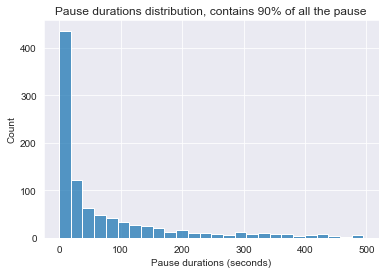

In [21]:
pauses = pause_duration(user_events, 500)
sns.histplot(pauses[0])
plt.xlabel("Pause durations (seconds)")
plt.title("Pause durations distribution, contains {:.0f}% of all the pause".format(pauses[1] * 100));

From the above histogram, 500 seconds (around 8 minutes) seems to be a reasonable threshold as 90% of all the pause durations are below this threshold and that as the duration increase the count tends to 0.

### Seek Length

In [32]:
def seek_length(user_events):
    user_events = user_events[user_events.EventType == 'Video.Seek']
    return abs(user_events.OldTime - user_events.NewTime).values

def avg_seek_length(user_events):
    return seek_length(user_events).mean()

def std_seek_length(user_events):
    return seek_length(user_events).std()

print("Seek length")
print("Average",avg_seek_length(user_events))
print("SG",std_seek_length(user_events))

Seek length
Average 61.65760840963855
SG 206.35484738063911


### Time speeding-up video

In [33]:
def compute_speedchange_current_time(user_events):
    """Compute the CurrentTime of the SpeedChange event as it is not logged in the db
    For that we find the closest event (in the same video and day) with a non null CurrentTime
    Then we compute the SpeedChange CurrentTime with the delta time between the 2 events"""

    #Keep only SpeedChange events and events with non null CurrentTime
    df = user_events[(user_events.EventType == 'Video.SpeedChange') | (~user_events.CurrentTime.isna())]
    #Compute the deltatime between the previous events
    df = df.sort_values(by="TimeStamp", ascending=True)
    df['NextDiff'] = abs(df.TimeStamp.diff())
    df['PrevDiff'] = abs(df.TimeStamp.diff(-1))

    ### Define the closest event information: VideoID, TimeStamp and CurrentTime ###
    df['NextVideoID'] = df.VideoID.shift()
    df['NextTimeStamp'] = df.TimeStamp.shift()
    df['NextCurrentTime'] = df.CurrentTime.shift()
    df['PrevVideoID'] = df.VideoID.shift(-1)
    df['PrevTimeStamp'] = df.TimeStamp.shift(-1)
    df['PrevCurrentTime'] = df.CurrentTime.shift(-1)

    df['ClosestVideoID'] = np.nan
    df['ClosestTimeStamp'] = np.nan
    df['ClosestCurrentTime'] = np.nan
    #If the next event is the closest
    df.loc[df.NextDiff <= df.PrevDiff, 'ClosestVideoID'] = df[df.NextDiff <= df.PrevDiff].NextVideoID
    df.loc[df.NextDiff <= df.PrevDiff, 'ClosestTimeStamp'] = df[df.NextDiff <= df.PrevDiff].NextTimeStamp
    df.loc[df.NextDiff <= df.PrevDiff, 'ClosestCurrentTime'] = df[df.NextDiff <= df.PrevDiff].NextCurrentTime
    #If the previous event is the closest
    df.loc[df.NextDiff > df.PrevDiff, 'ClosestVideoID'] = df[df.NextDiff > df.PrevDiff].PrevVideoID
    df.loc[df.NextDiff > df.PrevDiff, 'ClosestTimeStamp'] = df[df.NextDiff > df.PrevDiff].PrevTimeStamp
    df.loc[df.NextDiff > df.PrevDiff, 'ClosestCurrentTime'] = df[df.NextDiff > df.PrevDiff].PrevCurrentTime

    #Filter the SpeedChange events
    df = df[(df.EventType == 'Video.SpeedChange') & (df.VideoID == df.ClosestVideoID) &
               (~df.ClosestCurrentTime.isna())]
    df.drop(columns=['NextDiff', 'NextVideoID','NextTimeStamp',"NextCurrentTime",'PrevDiff', "PrevVideoID", 
                       "PrevTimeStamp", "PrevCurrentTime", "ClosestVideoID", 'SeekType', 'OldTime',
                       'NewTime', 'AccountUserID', 'Date', 'Year'],inplace=True)
    df['CurrentTime'] = df.ClosestCurrentTime + abs(df.TimeStamp - df.ClosestTimeStamp)

    #Duration are the same through the year, we can simply keep the first VideoID
    video_durations = get_dated_videos().drop_duplicates(subset=['VideoID']) 
    df = df.merge(video_durations, on=['VideoID'])
    df = df[df.CurrentTime < df.Duration]
    
    df.drop(columns=['ClosestTimeStamp', 'ClosestCurrentTime', 'Chapter', 'Subchapter', 'Source', 
                   'Due_date', 'Year'],inplace=True)
    return df

compute_speedchange_current_time(user_events)

,DataPackageID,VideoID,TimeStamp,EventType,CurrentTime,OldSpeed,NewSpeed,Duration
0,EPFL-AlgebreLineaire-2019,4fe3df7b0c064bf2b68d7bcbe2663743,1568987487,Video.SpeedChange,2.045042,1.5,1.0,542.0
1,EPFL-AlgebreLineaire-2019,1aa440de3b5540b8a81b349455c2bc0b,1568989172,Video.SpeedChange,0.021385,1.5,1.0,782.0
2,EPFL-AlgebreLineaire-2019,1aa440de3b5540b8a81b349455c2bc0b,1568989173,Video.SpeedChange,1.021385,1.0,1.5,782.0
3,EPFL-AlgebreLineaire-2019,8298affd57ae43d6a46c3c2a60777fba,1569073415,Video.SpeedChange,0.026094,1.0,1.5,707.0
4,EPFL-AlgebreLineaire-2019,ab810821cd8943ea8a0173e900af8417,1569182759,Video.SpeedChange,197.437000,1.0,2.0,1079.0
...,...,...,...,...,...,...,...,...
65,EPFL-AlgebreLineaire-2019,31917c7dcfc24176afbe761dfce79796,1575115316,Video.SpeedChange,0.012831,1.5,1.0,1053.0
66,EPFL-AlgebreLineaire-2019,1b0f66ea185d4fa5a1d77f4fc5aec779,1575816096,Video.SpeedChange,3.054867,1.0,1.0,1002.0
67,EPFL-AlgebreLineaire-2019,1b0f66ea185d4fa5a1d77f4fc5aec779,1575816100,Video.SpeedChange,1.054867,1.0,1.5,1002.0
68,EPFL-AlgebreLineaire-2019,17fd9f65c51d4298942167d3cc64ada0,1575821081,Video.SpeedChange,1.038582,1.5,1.0,618.0


In [50]:
def compute_time_speeding_up(user_events):
    """Compute the time spent with a high spedd (> 1) for each video"""
    df = user_events.copy()
    sc = compute_speedchange_current_time(user_events)[['TimeStamp', 'EventType', 'CurrentTime']]
    df = df.merge(sc, on=['TimeStamp', 'EventType'], how='left')
    df['CurrentTime'] = np.where(df.CurrentTime_y.isna(), df.CurrentTime_x, df.CurrentTime_y)
    df.drop(columns=['CurrentTime_x', 'CurrentTime_y'], inplace=True)
    df = df.sort_values(by='TimeStamp')

    def label_speed(row, speed):
        newSpeed = speed['value'] if np.isnan(row) else row
        speed['value'] = newSpeed
        return newSpeed

    speed = {"value": 1} # Create a mutable object instead of a simple integer in order to modify its value in the label_speed function
    df['Speed'] = df.NewSpeed.apply(lambda row: label_speed(row, speed))
    df['NextVideoID'] = df.VideoID.shift(-1)

    video_durations = get_dated_videos().drop_duplicates(subset=['VideoID'])[['VideoID', 'Duration']]
    df = df.merge(video_durations)

    df['SpeedUpTime'] = abs(df.TimeStamp.diff(-1))

    #If the SpeedUpTime is Nan (last elem of DataFrame) or if the next events is in another video
    #then the time speeding up is until the end of the video
    conditions = (df.SpeedUpTime.isna()) | (df.VideoID != df.NextVideoID)
    df['SpeedUpTime'] = np.where(conditions, df.Duration - df.CurrentTime, df.SpeedUpTime)

    #When the speed is switched back to normal or slower then we stop counting
    conditions = (df.Speed <= 1) | (df.EventType.isin(['Video.Stop', 'Video.Pause'])) | \
                (df.SpeedUpTime > 3600)
    df['SpeedUpTime'] = np.where(conditions, 0, df.SpeedUpTime)
    return df.groupby('VideoID').SpeedUpTime.sum().values

def avg_time_speeding_up(user_events):
    return compute_time_speeding_up(user_events).mean()

def std_time_speeding_up(user_events):
    return compute_time_speeding_up(user_events).std()

speed = 1
print("Time speeding up")
print("Average",avg_time_speeding_up(user_events))
print("SG",std_time_speeding_up(user_events))

Time speeding up
Average 903.4878039215686
SG 650.7587703954882


## Grade - feature correlation

In [54]:
aied_features = [total_views, avg_weekly_prop_watched, std_weekly_prop_watched, avg_weekly_prop_replayed,
    std_weekly_prop_replayed, avg_weekly_prop_interrupted, std_weekly_prop_interrupted, total_actions,
    frequency_all_actions, freq_play, freq_pause, freq_seek_backward, freq_seek_forward,freq_speed_change,
    freq_stop, avg_pause_duration, std_pause_duration, avg_seek_length, std_seek_length, avg_time_speeding_up, std_time_speeding_up]

In [178]:
from tqdm import tqdm_notebook, tnrange
from time import sleep

def compute_feature_vector(video_events, userId, aied_features):
    user_events = video_events.loc[video_events.AccountUserID == userId]
    features_vector = [userId]
    for feat_func in tqdm_notebook(aied_features, desc="Feature loop", leave=False):
        features_vector.append(feat_func(user_events))
        sleep(0.01)
    return features_vector

# Compute the features for every students
def compute_features_df(video_events, aied_features):
    users = video_events.AccountUserID.unique()
    features_array = []
    for user in tqdm_notebook(users, desc="User loop", leave=False):
        features_array.append(compute_feature_vector(video_events, user, aied_features))
    columns = ["AccountUserID"] + list(map(lambda func: func.__name__, aied_features))
    return pd.DataFrame(features_array, columns=columns)

In [207]:
compute_feature_vector(events, "18422", aied_features)

['18422',
 131,
 0.6972405372405373,
 0.37290747472253855,
 0.08987484737484737,
 0.09161292670783444,
 0.1345848595848596,
 0.13206607167995404,
 4065,
 4.6784199298727405,
 0.43739237392373925,
 0.4150061500615006,
 0.012054120541205412,
 0.009102091020910209,
 0.005412054120541206,
 0.02779827798277983,
 47.85451197053407,
 80.07571048872693,
 173.77237999999997,
 230.00152378749962,
 500.79916326315794,
 424.2872197254752]

In [209]:
compute_feature_vector(events, "100402", aied_features)

['100402',
 99,
 0.8102564102564103,
 0.3562349688859857,
 0.01952662721893491,
 0.04699580982642552,
 0.044378698224852076,
 0.10752962548260876,
 1405,
 4.6219963780847095,
 0.3302491103202847,
 0.07473309608540925,
 0.22633451957295372,
 0.022775800711743774,
 0.12740213523131672,
 0.04412811387900356,
 82.98936170212765,
 89.54785891221961,
 44.90929303977273,
 49.21778945794014,
 334.5920517934782,
 229.13687670695322]

In [210]:
features_df = compute_features_df(events, aied_features)

In [112]:
features_df.head()

,AccountUserID,total_views,avg_weekly_prop_watched,std_weekly_prop_watched,avg_weekly_prop_replayed,std_weekly_prop_replayed,avg_weekly_prop_interrupted,std_weekly_prop_interrupted,total_actions,frequency_all_actions,...,freq_seek_backward,freq_seek_forward,freq_speed_change,freq_stop,avg_pause_duration,std_pause_duration,avg_seek_length,std_seek_length,avg_time_speeding_up,std_time_speeding_up
0,95017,158,0.849976,0.171214,0.219494,0.294374,0.163091,0.231592,5312,4.578708,...,0.066642,0.063253,0.026355,0.020143,39.831468,71.550800,76.318266,160.562579,398.989059,453.446221
1,99055,133,0.335491,0.312886,0.202470,0.210832,0.112013,0.138063,8901,5.115166,...,0.032244,0.034266,0.018874,0.005168,19.589356,53.933786,80.550911,187.876661,909.970808,809.211040
2,47274,271,0.359114,0.315056,0.529855,0.331175,0.142456,0.131952,8589,4.731550,...,0.088602,0.090465,0.011759,0.012807,71.462028,94.137362,43.633599,96.109135,1368.563139,878.900976


In [148]:
grades = getFlippedGrades(False)[['AccountUserID', 'Grade']]
graded_features = features_df.merge(grades)
graded_features

,AccountUserID,total_views,avg_weekly_prop_watched,std_weekly_prop_watched,avg_weekly_prop_replayed,std_weekly_prop_replayed,avg_weekly_prop_interrupted,std_weekly_prop_interrupted,total_actions,frequency_all_actions,...,freq_seek_forward,freq_speed_change,freq_stop,avg_pause_duration,std_pause_duration,avg_seek_length,std_seek_length,avg_time_speeding_up,std_time_speeding_up,Grade
0,95017,158,0.849976,0.171214,0.219494,0.294374,0.163091,0.231592,5312,4.578708,...,0.063253,0.026355,0.020143,39.831468,71.550800,76.318266,160.562579,398.989059,453.446221,5.25
1,99055,133,0.335491,0.312886,0.202470,0.210832,0.112013,0.138063,8901,5.115166,...,0.034266,0.018874,0.005168,19.589356,53.933786,80.550911,187.876661,909.970808,809.211040,2.00
2,47274,271,0.359114,0.315056,0.529855,0.331175,0.142456,0.131952,8589,4.731550,...,0.090465,0.011759,0.012807,71.462028,94.137362,43.633599,96.109135,1368.563139,878.900976,3.50


In [159]:
def compute_corr(df):
    feature_cols = list(df.columns)
    feature_cols.remove('AccountUserID')
    feature_cols.remove('Grade')

    correlations = []
    for col in feature_cols:
        nor_corr = np.corrcoef(df[col], df["Grade"])[0][1]
        correlations.append(nor_corr)
        print("{:30s} {:.4f}".format(col, nor_corr))
    return correlations
compute_corr(graded_features);

total_views                    0.1261
avg_weekly_prop_watched        0.9054
std_weekly_prop_watched        -0.8812
avg_weekly_prop_replayed       0.0018
std_weekly_prop_replayed       0.6441
avg_weekly_prop_interrupted    0.9880
std_weekly_prop_interrupted    0.8608
total_actions                  -0.9208
frequency_all_actions          -0.9589
freq_play                      -0.7756
freq_pause                     -0.7183
freq_seek_backward             0.5695
freq_seek_forward              0.4772
freq_speed_change              0.5501
freq_stop                      0.9984
avg_pause_duration             0.3458
std_pause_duration             0.3967
avg_seek_length                -0.0605
std_seek_length                -0.2471
avg_time_speeding_up           -0.5640
std_time_speeding_up           -0.8065
